***
# Predict Book Sales Ranking in Amazon
### First Capstone project
***
<div class="span5 alert alert-info">

<p> The main steps of this project are: </p>
<ul>
  <li> 1.Scrape and parse Amazon Book Reviews as well as the meta data.</li>
  <li> 2.Data Wrangling</li>
    <ul>
      <li> Load in and join book review to meta data</li>
      <li> Organize review texts into a sparse data frame of word counts </li>
    </ul>
   <li>3.EDA of various predictor variables and segmentation of book sales ranking </li>
   <li>4.Construct a machine learning pipeline for nested cross-validation </li>
</ul>
</div>

***



In [1]:
import os
import pandas as pd
import numpy as np
import scipy
import re
from __future__ import print_function

from pprint import pprint
from time import time
import logging

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier

from sklearn.pipeline import Pipeline

import seaborn as sns

import matplotlib.pyplot as plt
# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


/Users/yizhao/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Automatically created module for IPython interactive environment


In [2]:
# load in the raw data as csv
joined_data = pd.read_csv('/Users/yizhao/Documents/First_capstone/joined_data.csv')

# load in earlier data frame of word counts
#spread_titles = pd.read_csv('/Users/yizhao/Documents/First_capstone/spread_titles.csv')
#spread_reviews = pd.read_csv('/Users/yizhao/Documents/First_capstone/spread_reviews.csv')

In [3]:
# parse out the bag of words for both Titles and the Reviews

X_titles = [''.join(r) for r in joined_data.review_titles]

X_reviews = [''.join(r) for r in joined_data.reviews]

y = joined_data.sales_rank.values # the prediction target
b = joined_data.list_name.astype(str).values # book list names

In [4]:
y_log = np.log(y)
y_log[:5]

array([ 2.89037176,  0.69314718,  4.18965474,  4.9698133 ,  4.35670883])

### Use Review titles to predict sales rank

In [40]:
# define a count vectorizer object
vec = CountVectorizer(min_df = 1, stop_words='english')

# fit and transform all the text data
X = vec.fit_transform(X_titles)

# split the data into training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)


In [41]:
# fit with Random forest regresson

RF = RandomForestRegressor(n_estimators= 100)
RF.fit(Xtrain, ytrain)

# assess accuracy
print('Titles Random forest fit')
print('Train explained variance: ',explained_variance_score(ytrain, RF.predict(Xtrain)))
print('Test explained variance: ',explained_variance_score( ytest, RF.predict(Xtest)))


Titles Random forest fit
Train explained variance:  0.858421805521
Test explained variance:  -0.507993823348


### Use review texts to predict sales rank

In [10]:
# fit and transform all the review data
vec = CountVectorizer(min_df = 1,  stop_words='english') # increase into bigram to see if results are better
#ngram_range=(1,2),

X = vec.fit_transform(X_reviews)

# split the data into training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)


# Fit Random forest regressor

RF = RandomForestRegressor(n_estimators= 100)
RF.fit(Xtrain, ytrain)

# assess accuracy
print('Review texts random forest fit')
print('Train explained variance: ',explained_variance_score(ytrain, RF.predict(Xtrain)))
print('Test explained variance: ',explained_variance_score( ytest, RF.predict(Xtest)))



Review texts random forest fit
Train explained variance:  0.840645104136
Test explained variance:  -0.128984321034


The test set fit is still disappointing, but it's slightly better than using the review titles. There is likely more indstinguishing information available in the review texts.

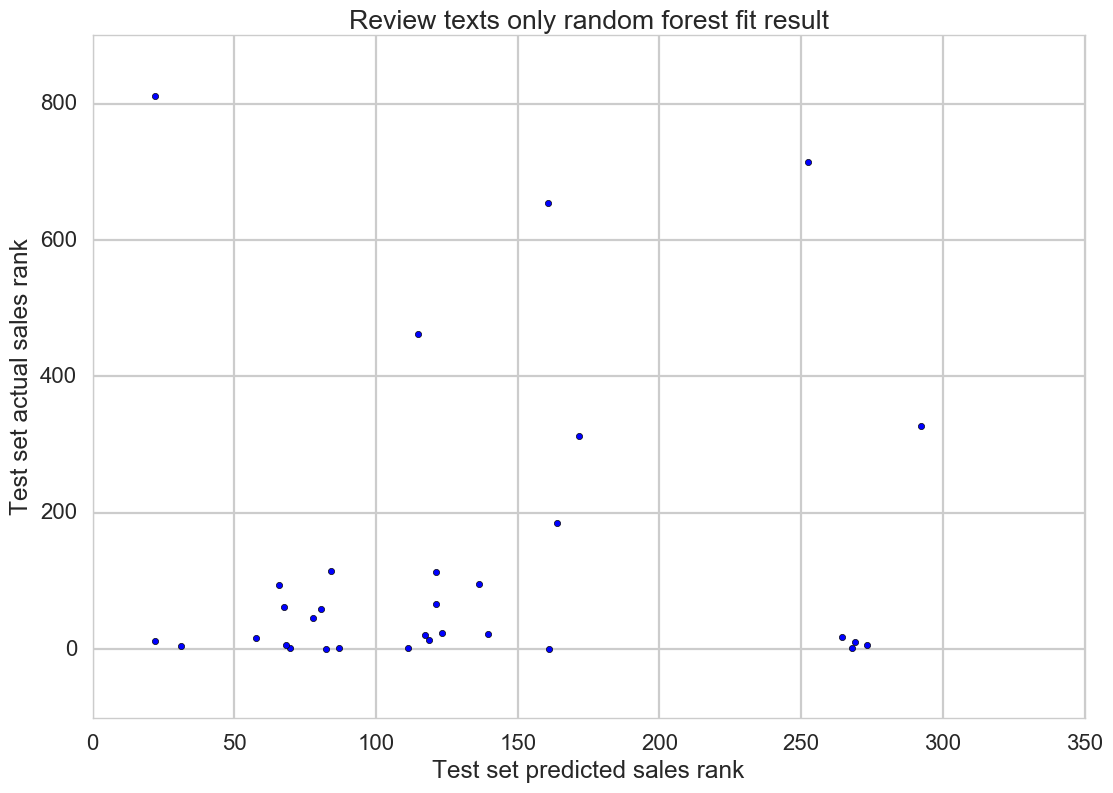

In [49]:
plt.scatter(RF.predict(Xtest), ytest)
plt.xlabel('Test set predicted sales rank')
plt.ylabel('Test set actual sales rank')
plt.title('Review texts only random forest fit result')
plt.show()

In [63]:
# try using log instead of y
# split the data into training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_log)


# Fit Random forest regressor

RF = RandomForestRegressor(n_estimators= 100)
RF.fit(Xtrain, ytrain)

# assess accuracy
print('Review texts random forest fit')
print('Train explained variance: ',explained_variance_score(ytrain, RF.predict(Xtrain)))
print('Test explained variance: ',explained_variance_score( ytest, RF.predict(Xtest)))



Review texts random forest fit
Train explained variance:  0.847313181991
Test explained variance:  0.136727049263


In [30]:
# count the number of occurences by word
#print(type(vec.get_feature_names))
review_wc = pd.Series(data= X.toarray().sum(axis=0), dtype= int,
                      index= vec.get_feature_names())

# list the highest occuring words
review_wc.sort_values(ascending=False)[:10]

In [59]:
# Try LASSO

lasso = linear_model.Lasso(alpha=2, max_iter=1e4)
lasso.fit(Xtrain, ytrain)

# assess accuracy
print('Train explained variance: ',explained_variance_score(ytrain, lasso.predict(Xtrain)))
print('Test explained variance: ',explained_variance_score( ytest, lasso.predict(Xtest)))


Train explained variance:  0.617257120113
Test explained variance:  -0.603849643924


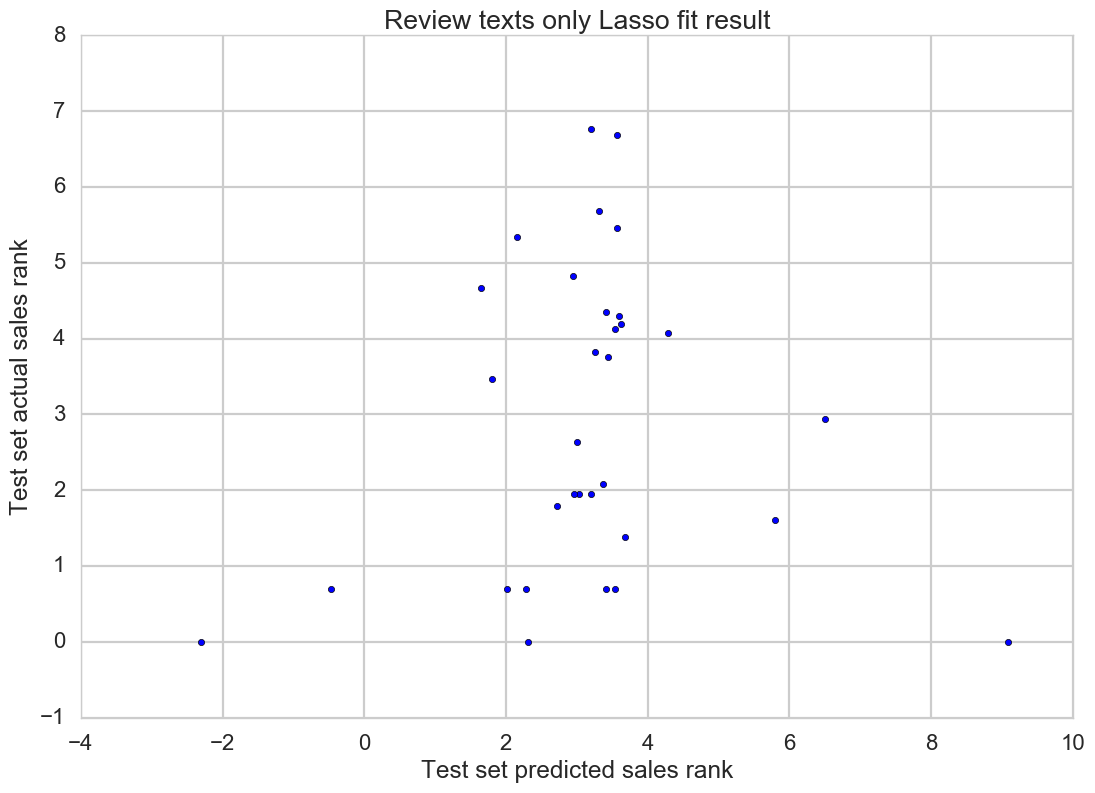

In [58]:
plt.scatter(lasso.predict(Xtest), ytest)
plt.xlabel('Test set predicted log(sales rank)')
plt.ylabel('Test set actual log(sales rank)')
plt.title('Review texts only Lasso fit result')
plt.show()

In [62]:
# try using Tf-idf
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(X_reviews)

# split the data into training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(Xtfidf, y_log)


# Fit Random forest regressor

RF = RandomForestRegressor(n_estimators= 100)
RF.fit(Xtrain, ytrain)

# assess accuracy
print('Review texts Xtfidf transform random forest fit')
print('Train explained variance: ',explained_variance_score(ytrain, RF.predict(Xtrain)))
print('Test explained variance: ',explained_variance_score( ytest, RF.predict(Xtest)))



Review texts Xtfidf transform random forest fit
Train explained variance:  0.848002790524
Test explained variance:  0.0836430095961


In [64]:
Xtfidf.shape

(126, 48209)

It seems that the training set's vairance explained is seven to ten times higher than the testing set. 
And using the Tfidf Transformer did not help with improving the model fit on the test set. 
This incidates that our model is significantly overfitting given our 48K plus predictor features. We need to reduce the number of features here.

### Feature dimension reduction using PCA

(126, 48209)
(126, 126)
(126, 48209)


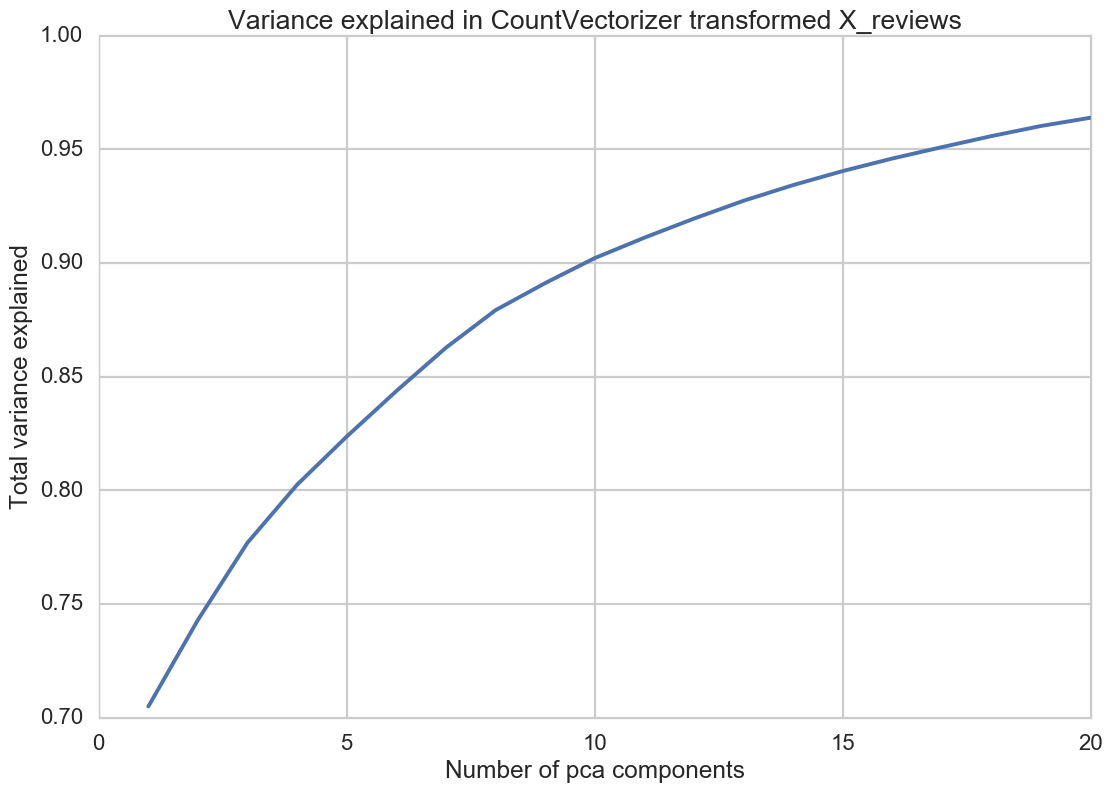

In [77]:
# first try the default number of components in PCA
# note: X = vec.fit_transform(X_reviews)
pca_default = PCA()
pca_fit = pca_default.fit(X.toarray())

pca_data = pca_default.transform(X.toarray())
print(pca_fit.components_.shape)
print(pca_data.shape)
print(X.toarray().shape)

# plot the amount of variance explained by having each additinal component
plt.plot(range(1, 21), 
         pca_default.explained_variance_ratio_.cumsum()[:20])
plt.xlabel('Number of pca components')
plt.ylabel('Total variance explained')
plt.title('Variance explained in CountVectorizer transformed X_reviews')
plt.show()

It looks like 10 pca components is a good cutoff point, explaining 90% of variance in the review text data.

In [80]:
# use the PCA fit to train a random forest model
pca = PCA(n_components= 10)

X = vec.fit_transform(X_reviews)
# split the data into training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_log)

# fit PCA on the training set
pca_Xtrain = pca.fit_transform(Xtrain.toarray())

# PCA transform the test set using the fit from the training set
pca_Xtest = pca.transform(Xtest.toarray())

# Fit Random forest regressor
RF = RandomForestRegressor(n_estimators= 100)
RF.fit(pca_Xtrain, ytrain)

# assess accuracy
print('Review texts PCA transformed random forest fit')
print('Train explained variance: ',explained_variance_score(ytrain, RF.predict(pca_Xtrain)))
print('Test explained variance: ',explained_variance_score( ytest, RF.predict(pca_Xtest)))



Review texts random forest fit
Train explained variance:  0.846070263111
Test explained variance:  0.155171452132


This test set fit is remarkably better than the previous result. 
However, if we use isoluate the vocabulary extration from training set and then performing the PCA transform, the resulting fit on the test set becomes worse, as follows:

In [79]:
# use the PCA fit to train a random forest model
pca = PCA(n_components= 10)

# split the data into training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X_reviews, y_log)

# transform text data for the training set
Xtrain_vec = vec.fit_transform(Xtrain)
# fit PCA on the training set
pca_Xtrain = pca.fit_transform(Xtrain_vec.toarray())

# transform text data for the testing set using the same vocab of training set
Xtest_vec = CountVectorizer(vocabulary= vec.vocabulary_).fit_transform(Xtest)
# PCA transform the test set using the fit from the training set
pca_Xtest = pca.transform(Xtest_vec.toarray())

# Fit Random forest regressor
RF = RandomForestRegressor(n_estimators= 100)
RF.fit(pca_Xtrain, ytrain)

# assess accuracy
print('Review texts PCA transformed random forest fit')
print('Train explained variance: ',explained_variance_score(ytrain, RF.predict(pca_Xtrain)))
print('Test explained variance: ',explained_variance_score( ytest, RF.predict(pca_Xtest)))


Review texts random forest fit
Train explained variance:  0.875809355196
Test explained variance:  -0.0169232307209


In [5]:
# Also try truncated SVD 
svd = TruncatedSVD(n_components = 10)

vec = CountVectorizer(min_df = 1, stop_words='english')
X = vec.fit_transform(X_reviews)
# split the data into training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y_log)

# fit SVD on the training set
svd_Xtrain = svd.fit_transform(Xtrain)

# SVD transform the test set using the fit from the training set
svd_Xtest = svd.transform(Xtest)

# Fit Random forest regressor
RF = RandomForestRegressor(n_estimators= 100)
RF.fit(svd_Xtrain, ytrain)

# assess accuracy
print('Review texts SVD transformed random forest fit')
print('Train explained variance: ',explained_variance_score(ytrain, RF.predict(svd_Xtrain)))
print('Test explained variance: ',explained_variance_score( ytest, RF.predict(svd_Xtest)))




Review texts SVD transformed random forest fit
Train explained variance:  0.845541208916
Test explained variance:  0.0840053275502


The number of components used for this SVD fit is exactly the same as PCA, but the test result is not nearly as good. The training explained variance is very similar though.

#### EDA on relationship between review texts and the book lists
What if using the review texts to predict the categories of books, as opposed to the sales rank? What that yield a much more accurate result?

In [13]:
vec = CountVectorizer(min_df = 1,  stop_words='english') # increase into bigram to see if results are better
#ngram_range=(1,2),

X = vec.fit_transform(X_reviews)

# split the data into training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, b)


# Fit Random forest classifier

RF = RandomForestClassifier(n_estimators= 100)
RF.fit(Xtrain, ytrain)

# assess accuracy
print('Review texts random forest classifier fit')
print('Train accuracy: ',accuracy_score(RF.predict(Xtrain), ytrain))
print('Test accuracy: ',accuracy_score( RF.predict(Xtest), ytest))




Review texts random forest classifier fit
Train accuracy:  1.0
Test accuracy:  0.5625


The test accuracy isn't great, but better than prediction results of the sales rank. What if the 'best_seller' list is removed (that list may have books with various different genres).

In [14]:
joined_data.list_name.unique()

array(['lifetime', 'thriller', 'best_seller', 'biography', 'children'], dtype=object)

In [22]:
sub_data = joined_data[joined_data.list_name.values != 'best_seller']
sub_reviews = [''.join(r) for r in sub_data.reviews]

sub_ylog = np.log(sub_data.sales_rank.values)
sub_b = sub_data.list_name.astype(str).values 

In [20]:
vec = CountVectorizer(min_df = 1,  stop_words='english') # increase into bigram to see if results are better
#ngram_range=(1,2),

X = vec.fit_transform(sub_reviews)

# split the data into training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, sub_b)


# Fit Random forest classifier

RF = RandomForestClassifier(n_estimators= 100)
RF.fit(Xtrain, ytrain)

# assess accuracy
print('Review texts random forest classifier fit')
print('Train accuracy: ',accuracy_score(RF.predict(Xtrain), ytrain))
print('Test accuracy: ',accuracy_score( RF.predict(Xtest), ytest))




Review texts random forest classifier fit
Train accuracy:  1.0
Test accuracy:  0.72


Indeed, the classification accuracy becomes much better with the 'best_seller' list removed.
What about the sales ranking then?

In [25]:
# split the data into training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, sub_ylog)

pca = PCA(n_components= 10)
# fit PCA on the training set
pca_Xtrain = pca.fit_transform(Xtrain.toarray())

# PCA transform the test set using the fit from the training set
pca_Xtest = pca.transform(Xtest.toarray())


# Fit Random forest regressor
RF = RandomForestRegressor(n_estimators= 100)
RF.fit(pca_Xtrain, ytrain)

# assess accuracy
print('Review texts non best-seller list random forest fit')
print('Train explained variance: ',explained_variance_score(ytrain, RF.predict(pca_Xtrain)))
print('Test explained variance: ',explained_variance_score( ytest, RF.predict(pca_Xtest)))



Review texts non best-seller list random forest fit
Train explained variance:  0.862096389027
Test explained variance:  -0.499366464512


Removing 'best_selling' books improved the fit for book list names, but not for the sales rank.
So the book list information is not as significant to the sales ranking.

#### Try Kmeans and hierarchical clustering and see if there is any seperability in the sales ranking distributions of various clusters.

In [9]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [10]:
vec = CountVectorizer(min_df = 1,  stop_words='english') 

X = vec.fit_transform(X_reviews)

In [12]:
# compute the score for Kmeans fits of a range of n_clusters

K = range(2,21,1) # try out K for values 2 to 20

# a list of fitted Kmeans results
KM = [KMeans(n_clusters=k).fit(X) for k in K]

NameError: name 'x_cols' is not defined

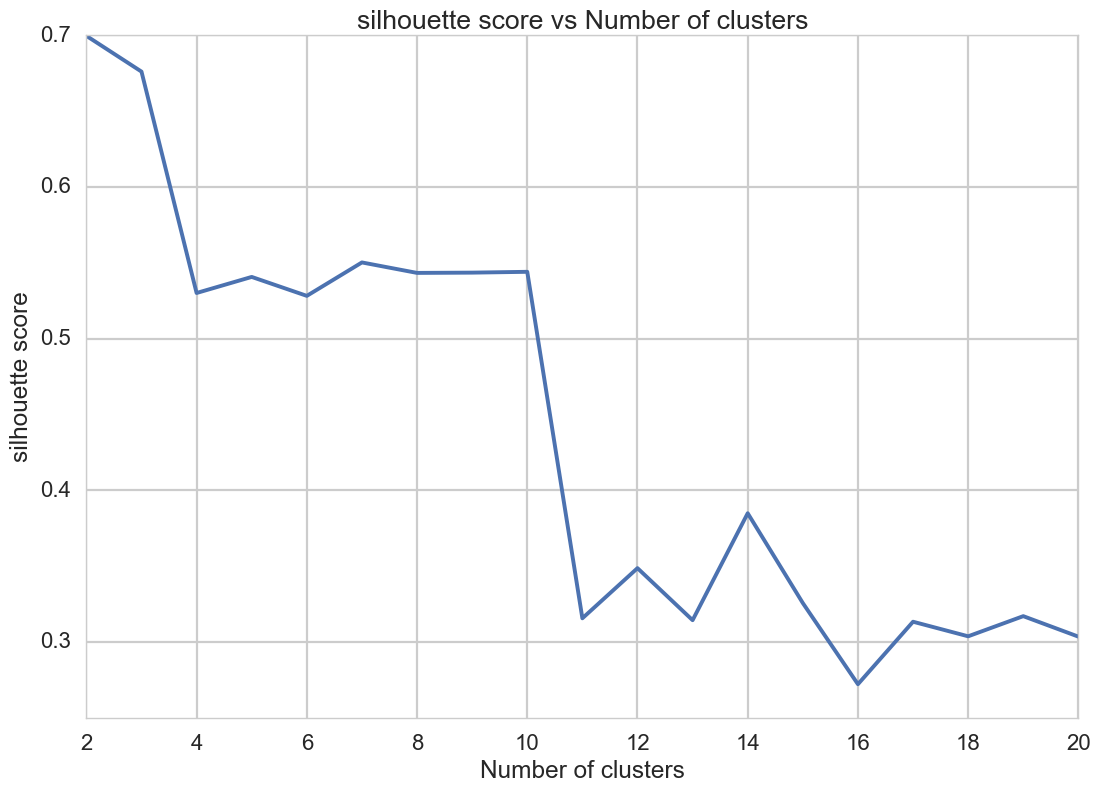

In [13]:
# a list of centroids from the previous KM fits
sh_score = [silhouette_score(X = X,
                             labels = k.predict(X)) for k in KM]

plt.plot(K,  sh_score)
plt.xlabel('Number of clusters')
plt.ylabel('silhouette score')
plt.title('silhouette score vs Number of clusters')
plt.show()

Ideally, the silouette score should increase with an increasing number of clusters, but it doesn't seem to be the case here. 2 clusters has the best score.

In [16]:
# fit the agglomerative clustering
ac = AgglomerativeClustering()  # default is 2 clusters

ac_labels = ac.fit_predict(X.toarray())

print('Silhouette score: \n')
print(silhouette_score(X.toarray(), ac_labels, metric='euclidean'))

# the score looks the same as the Kmean result

Silhouette score: 

0.699768032644


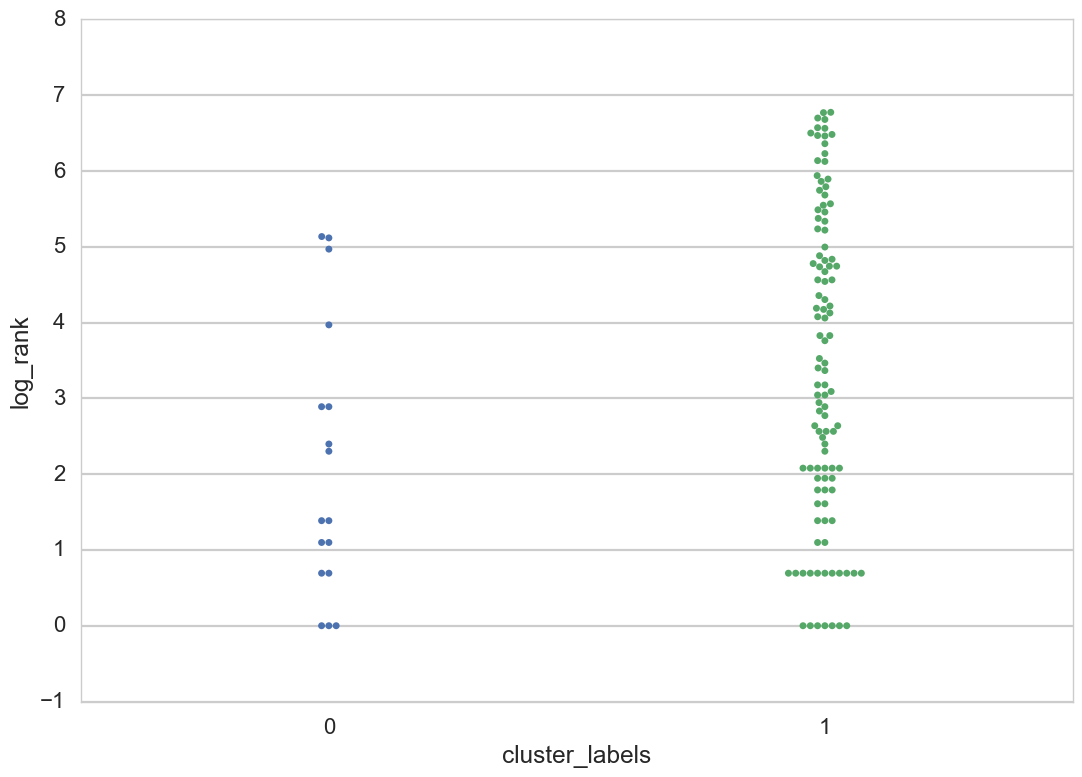

In [22]:
toplot = pd.DataFrame({"cluster_labels": ac_labels,
                      'log_rank': y_log})
sns.swarmplot(x="cluster_labels", y="log_rank", data=toplot)
plt.show()

At least one cluster has a smaller range in sales rank than the other, but there doesn't seem to be any significant differences between the two clusters.

### Optimize the parameters to count vectorizer

In [7]:
# try a pipeline with random forest instead

pipeline = Pipeline([
    #('vect', CountVectorizer(stop_words= 'english')),
    
    #('pca', PCA()),
    ('svd', TruncatedSVD()),
    ('RF', RandomForestRegressor(n_estimators = 100)),
])
parameters = {
#    'vect__min_df': (1,2,3),
#    'vect__max_features': (None, 3000,5000),
#    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'pca__n_components':(10,20,40),
    'svd__n_components':(10,20,40),
    #'RF__n_estimators': (100,200,500),
    'RF__min_impurity_split': (1e-7,1e-5,1e-3,0.01)
}

In [8]:
if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X, y_log)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['svd', 'RF']
parameters:
{'RF__min_impurity_split': (1e-07, 1e-05, 0.001, 0.01),
 'svd__n_components': (10, 20, 40)}
Fitting 3 folds for each of 12 candidates, totalling 36 fits


Process ForkPoolWorker-12:
Process ForkPoolWorker-10:
Process ForkPoolWorker-11:
Process ForkPoolWorker-9:


KeyboardInterrupt: 

### Last bet: put the currently best model from PCA transformation together with the rest of the predictor variables


In [36]:
# use the PCA fit to train a random forest model
pca = PCA(n_components= 14)

X = vec.fit_transform(X_reviews)

vars_add = np.column_stack((#b,
                     np.log(joined_data.review_count.values),
                     joined_data.date_delta.values,# relative measure of publish date
                    #joined_data.publisher.values
                    ))
X = np.column_stack((X.toarray(), 
                     vars_add)) 

In [44]:
X[~np.isnan(X).any(axis=1)].shape


(117, 48211)

In [53]:


# split the data into training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X[~np.isnan(X).any(axis=1)],
                                                y_log[~np.isnan(X).any(axis=1)])

added_n = vars_add.shape[1]
# fit PCA on the training set
pca_Xtrain = pca.fit_transform(Xtrain[:,:-added_n])

# PCA transform the test set using the fit from the training set
pca_Xtest = pca.transform(Xtest[:,:-added_n])

train_set = np.column_stack((pca_Xtrain,Xtrain[:,-added_n:]))
test_set = np.column_stack((pca_Xtest,Xtest[:,-added_n:]))

# Fit Random forest regressor
RF = RandomForestRegressor(n_estimators= 100)
RF.fit(train_set, ytrain)

# assess accuracy
print('All variables PCA transformed random forest fit')
print('Train explained variance: ',explained_variance_score(ytrain, RF.predict(train_set)))
print('Test explained variance: ',explained_variance_score( ytest, RF.predict(test_set)))



/Users/yizhao/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 126 but corresponding boolean dimension is 117


All variables PCA transformed random forest fit
Train explained variance:  0.834406454404
Test explained variance:  0.0982568026132


The results are unstable, as the test set explained variance changes significantly from run to run. 